# edu-cater 

In [1]:
# imports

from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import os
import json
import csv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import pandas as pd
import numpy as np
import pickle
import time
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import ldamodel
import gensim.corpora

import pyLDAvis
from pyLDAvis import gensim as pyldagensim
import networkx as nx

from warnings import filterwarnings
filterwarnings('ignore')


[nltk_data] Downloading package wordnet to /home/amandae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
tmp = np.zeros((10,10))
tmp[2,3] = 5
tmp[3,5] = 2
tmp[5,8] = 2
tmp[0,4] = 3
tmp[1,2] = 4
tmp[7,9] = 2

G = nx.from_numpy_matrix(tmp)
shortpath = nx.algorithms.shortest_path(G,2,8)

for i in range(8):
    if np.sum(i==shortpath)>0:
        print(i)

# trying linear regression to predict enrollment from TF-IDF

In [ ]:
from gensim.models import TfidfModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = TfidfModel(bow_corpus)  # fit model
tfidf_corpus = model[bow_corpus]

mat = np.zeros((len(dictionary),len(tfidf_corpus)))
for i, doc in enumerate(tfidf_corpus):
    for j in doc:
        mat[j[0], i] = j[1]

mat = mat.T

X = mat
y = np.log10(enrollment)
inds = np.where(np.isnan(y)==0)[0]
y = y[inds]
X = X[inds,:]

lm = LinearRegression()
lm.fit(X,y)

In [ ]:
# cross validation

lm = LinearRegression()
cv_scores = cross_val_score(lm, X, y, cv=3)
print('Mean CV accuracy = ', np.mean(cv_scores)*100, '%')
print('SD of CV accuracy = ', np.std(cv_scores)*100, '%')
print('Median CV accuracy = ', np.median(cv_scores)*100, '%')


In [ ]:
# CV manually

n = np.shape(X)[0]
inds = np.random.permutation(n)
Xperm = X[inds,:]
yperm = y[inds]
inds = inds.reshape((int(n/8),-1))

scores = []
for i in range(8):
    print(i)
    testinds = inds[:,i]
    traininds = np.setdiff1d(np.arange(n),testinds)
    Xtrain = X[traininds,:]
    ytrain = y[traininds]
    Xtest = X[testinds,:]
    ytest = y[testinds]
    lm = LinearRegression()
    lm.fit(Xtrain, ytrain)
    ypred = lm.predict(Xtrain)
    score = np.corrcoef(ypred,ytrain)[1][0]**2
    scores.append(score)
    
print(scores)

In [ ]:
# plots

ypred = lm.predict(X)
print(lm.score(X,y))
print(np.corrcoef(y,ypred)[1,0]**2)
print(lm.coef_.shape)
plt.scatter(y,ypred); plt.show()
plt.figure(figsize=(18,5))
#ax = fig.add_subplot(111, facecolor='black')
plt.scatter(np.arange(len(dictionary)), model.coef_,s=1,c=model.coef_,cmap='inferno',facecolor='black'); plt.show()

# topic-topic similarity based on word2vec

In [ ]:
# word2vec

# generate and save
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(processed_info, size=500, min_count=1, sg=1)
w2v_model.save("w2v-model.bin")

# load model
w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

In [ ]:
# median similarity of terms between topics

sim_all = np.zeros((ntopics, ntopics))
for i in range(ntopics):
    topic_terms = lda_model.get_topic_terms(i, topn=30)
    top_terms1 = []
    for x in range(len(topic_terms)):
        top_terms1.append(dictionary[topic_terms[x][0]])
    for j in range(ntopics):
        topic_terms = lda_model.get_topic_terms(j, topn=30)
        top_terms2 = []
        for x in range(len(topic_terms)):
            top_terms2.append(dictionary[topic_terms[x][0]])
        
        sim_topic = np.zeros((30,30))
        for term1 in range(len(top_terms1)):
            for term2 in range(len(top_terms2)):
                sim = w2v_model.similarity(top_terms1[term1], top_terms2[term2]) 
                sim_topic[term1, term2] = sim
        sim_all[i, j] = np.median(sim_topic)


In [ ]:
# plot of term similarities between topics 

mask = np.zeros_like(sim_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

uptri_vals = np.triu(sim_all)
uptri_vals = uptri_vals[uptri_vals>0]
print('Median term similarity:', np.median(uptri_vals))

plt.figure(figsize=(7,6))
sns.heatmap(sim_all, mask=mask, cmap='magma', vmin=np.round(np.min(uptri_vals),2),
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Topic-Topic median term similarity')
plt.show()

## OLD FUNCTIONS

In [ ]:
def doctopics(ind): 
    unseen_document = course_info_all[ind]
    bow_vector = dictionary.doc2bow(preprocess(unseen_document))
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
    return topic_scores
    
scoremat = np.zeros((len(course_info_all),ntopics))

for i in range(len(course_info_all)):
    scoremat[i,:] = doctopics(i)
    
savemat('edu-app/scoremat.mat',{'scoremat': scoremat}

In [ ]:
nodes = []
links = []
for i in range(len(G.nodes())):
    nodes.append({'id': titles[i], 'group': 1}) #int(values[i])})
    if list_edges[i][0] != list_edges[i][1]:
        #links.append({'source': titles[list_edges[i][0]], 'target': titles[list_edges[i][1]], 'value': 1})
        links.append({'source': list_edges[i][0], 'target': list_edges[i][1], 'value': 1})
    
coursenet = dict({'nodes': nodes, 'links': links})
    
# save course_info
file = 'edu-app/static/course_network.json'
with open(file, 'w') as fp:
    json.dump(coursenet, fp)

In [ ]:
    def create_db(self):
        sqlite_file = 'edu-cater_db.sqlite'
        conn = sqlite3.connect(sqlite_file)
        c = conn.cursor()
        c.execute('CREATE TABLE CourseraInfo(title TEXT PRIMARY KEY, description TEXT, \
                  syllabus_headings TEXT, syllabus_descriptions TEXT, nreviews INTEGER, level TEXT, hours INTEGER, \
                  stars FLOAT, enrollment INTEGER, skills TEXT, occupations TEXT)')
        conn.commit()
        conn.close()
        
    def write_to_sql(self):
        sqlite_file = 'edu-cater_db.sqlite'
        conn = sqlite3.connect(sqlite_file)
        c = conn.cursor()
        c.execute('''INSERT INTO CourseraInfo(title, description, syllabus_headings, syllabus_descriptions, nreviews, level, hours, stars, enrollment, skills, occupations)
              VALUES(?,?,?,?,?,?,?,?,?,?,?)''', (title, description, syllabus_headings, syllabus_descriptions, nreviews, level, hours, stars, enrollment, ''.join(skills), ''.join(occupations)))
        conn.commit()
        conn.close()

In [ ]:
# this is how pcoa works in pyldavis

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]


def pcoa(pair_dists, n_components=2):

    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)

    return np.sqrt(eigvals) * eigvecs

In [ ]:
# plot distribution of weights (costs)

print(np.percentile(list_weighted_costs,95))
plt.hist(list_weighted_costs,20); plt.show()
plt.hist(edge_weights,20); plt.show()

In [ ]:
# test: shortest path chooses lower weight

g2 = nx.Graph()
g2.add_edge(1, 2, weight=.5)
g2.add_edge(2, 4, weight=1)
g2.add_edge(1, 3, weight=.3)
g2.add_edge(3, 4, weight=1)

shortest_path(g2,1,4,weight='weight')

In [ ]:
# check for English courses
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    

for i, title in enumerate(titles_all):
    if isEnglish(title)==False:
        print(i, title)
        print(scraper.urls_all[i])

sometimes recommendations show up twice!
e.g.
https://www.coursera.org/learn/matlab

# testing different topic modeling techniques

In [2]:
# good code
# https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token!='youâ':
            result.append(lemmatize_stemming(token))
            
    return result

In [37]:
# aggregate all text info (description, syllabus) and preprocess

processed_info = []
nreviews = []
stars = []
hours = []
levels = []
enrollment = []
course_info_all = []
titles_all = []
skills_all = []
for i in range(2635): #fixthis
    if i%500 == 0:
        print(i)
    with open('course_info_short/course' + str(i) + '.json') as json_file:
        course_info = json.load(json_file)
    allinfo = course_info['title'] + ' ' + course_info['description'] \
            + ' ' + course_info['syllabus_headings'] + ' ' + course_info['syllabus_descriptions'] 
    tmpskills = ''
    for skill in course_info['skills']:
        allinfo = allinfo # +  ' ' + skill
        tmpskills = tmpskills + ' ' + skill
    for occupation in course_info['occupations']:
        allinfo = allinfo # + ' ' + occupation
    for review in course_info['reviews']:
        allinfo = allinfo  # + ' ' + review
    nreviews.append(course_info['nreviews'])
    stars.append(course_info['stars'])
    hours.append(course_info['hours'])
    levels.append(course_info['level'])
    enrollment.append(course_info['enrollment'])
    titles_all.append(course_info['title'])
    
    allinfo.replace('[^A-Za-z0-9]+', ' ')
    tmpskills.replace('[^A-Za-z0-9]+', ' ')
   
    processed_info.append(preprocess(allinfo))
    skills_all.append(preprocess(tmpskills))
    course_info_all.append(allinfo)
    
# save course titles for web app
file = open('simple_app/course_titles.pkl', 'wb')
pickle.dump(titles_all, file)
file.close()


0
500
1000
1500
2000
2500


In [108]:
# TF-IDF preprocessing for LDA with sklearn

stop = list(set(stopwords.words('english')))
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words=stop, max_df=.5, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X = tfv.fit_transform(clean_text)  #.todense()
featnames = tfv.get_feature_names()
X


<2635x3188 sparse matrix of type '<class 'numpy.float64'>'
	with 300455 stored elements in Compressed Sparse Row format>

In [18]:
# LDA using sklearn: GridSearchCV

# Define Search Param
ntopics_list = [10, 15, 20, 25, 30]
search_params = {'n_components': ntopics_list, 'learning_decay': [.9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

# Best Model
best_lda_model = model.best_estimator_

# print results
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(X))

plt.plot(ntopics_list, model.cv_results_['mean_test_score'])

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -57343.84937208518
Model Perplexity:  4957.472230185666


In [106]:
from pyLDAvis import sklearn as pyldavis_sklearn

#gensim.models.hdpmodel
#gensim.models.ldamodel.LdaModel?

model = LatentDirichletAllocation(n_components=25, random_state=42) 
model.fit_transform(X)

vis_data = pyldavis_sklearn.prepare(model, X, tfv, mds='tsne')

pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)

# sklearn coherence: custom code
https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

In [109]:
# word2vec

# generate and save
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(processed_info, size=500, min_count=1, sg=1)
w2v_model.save("w2v-model.bin")

# load model
w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

# load terms
terms = tfv.get_feature_names()

In [110]:
# define functions

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [111]:
# run topic models

topic_models_lda = []
topic_models_nmf = []

kvals = [10, 15, 20, 25, 30, 35]

for k in kvals:
    
    print(k)
    
    model = LatentDirichletAllocation(n_components=k, random_state=42) 
    W = model.fit_transform(X)
    H = model.components_    
    topic_models_lda.append((k,W,H))
    
    model = NMF(init="nndsvd", n_components=k, random_state=42) 
    W = model.fit_transform(X)
    H = model.components_ 
    #p = model.perplexity(X)
    topic_models_nmf.append((k,W,H))

10
15
20
25
30
35


In [112]:
coherences_lda = []
for (k,W,H) in topic_models_lda:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    # Now calculate the coherence based on our Word2vec model
    coherences_lda.append(calculate_coherence(w2v_model, term_rankings))
    print("K=%02d: Coherence=%.4f" % (k, coherences_lda[-1]))
    
coherences_nmf = []
for (k,W,H) in topic_models_nmf:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    # Now calculate the coherence based on our Word2vec model
    coherences_nmf.append(calculate_coherence(w2v_model, term_rankings))
    print("K=%02d: Coherence=%.4f" % (k, coherences_nmf[-1]))

K=10: Coherence=0.5234
K=15: Coherence=0.5340
K=20: Coherence=0.5396
K=25: Coherence=0.5521
K=30: Coherence=0.5763
K=35: Coherence=0.5755
K=10: Coherence=0.5514
K=15: Coherence=0.5491
K=20: Coherence=0.5702
K=25: Coherence=0.5724
K=30: Coherence=0.5720
K=35: Coherence=0.5846


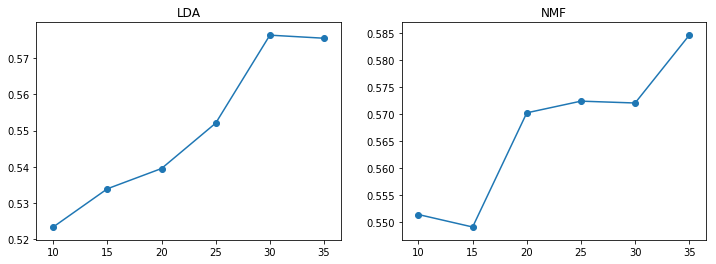

In [113]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.plot(kvals, coherences_lda)
plt.scatter(kvals, coherences_lda)
plt.title('LDA')

fig.add_subplot(122)
plt.plot(kvals, coherences_nmf)
plt.scatter(kvals, coherences_nmf)
plt.title('NMF')
plt.show()

In [114]:
from gensim.models.coherencemodel import CoherenceModel
CoherenceModel?

# more topic modeling stuff

In [15]:
# make dictionary
dictionary = gensim.corpora.Dictionary(processed_info)
print('Length of original dictionary:', len(dictionary))

# remove rare and common words
dictionary.filter_extremes(no_below=10, no_above=.95, keep_n=100000)
print('Length of filtered dictionary:', len(dictionary))

# make bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_info]

Length of original dictionary: 19894
Length of filtered dictionary: 3200


In [12]:
# NMF
# https://github.com/ravishchawla/topic_modeling/blob/master/topic_modeling.ipynb

train_headlines_sentences = [' '.join(text) for text in processed_info]

vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(train_headlines_sentences);


transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [13]:
#obtain a NMF model.

num_topics = 20
model = NMF(n_components=num_topics, init='nndsvd');

#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=20, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [14]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);


get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,cours,data,cloud,busi,health,blockchain,feedback,sale,game,chines,market,financi,kubernet,secur,chain,informat,design,project,music,model
1,learn,analysi,bigqueri,innov,healthcar,bitcoin,geben,manag,uniti,mandarin,brand,account,googl,network,suppli,leadership,user,capston,musician,regress
2,great,scienc,googl,strategi,care,technolog,negat,plan,cours,china,price,financ,cloud,cybersecur,financ,nurs,graphic,plan,chord,linear
3,week,clinic,qwiklab,manag,patient,evolut,posit,compens,gameplay,extens,strategi,statement,architect,engin,manag,leader,manufactur,manag,sonata,machin
4,good,analyt,platform,cours,medic,currenc,processo,train,week,cours,product,invest,qwiklab,cours,analyt,team,softwar,review,copyright,learn
5,thank,visual,union,modul,popul,proof,die,recruit,program,cultur,social,cash,engin,attack,supplier,coach,fusion,special,cours,deep
6,teach,python,data,sustain,diseas,cours,come,forc,develop,intermedi,media,cours,platform,cyber,oper,skill,interfac,final,beethoven,statist
7,help,analyst,join,compani,public,digit,quest,modul,player,lesson,custom,asset,deploy,system,cours,intervent,autodesk,peer,record,neural
8,program,scientist,lab,corpor,global,account,tempo,toolkit,anim,charact,cours,corpor,ãµes,cloud,logist,educ,prototyp,mileston,artist,network
9,excel,databas,servic,strateg,cannabi,hash,termin,strateg,creat,english,digit,risk,como,manag,program,cultur,modul,week,rock,variabl


In [5]:
# latent semantic analysis
# https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

detokenized_doc = []
for i in range(len(processed_info)):
    t = ' '.join(processed_info[i])
    detokenized_doc.append(t)

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 5000,
max_df = 0.5, 
smooth_idf=True)
X = vectorizer.fit_transform(detokenized_doc)


# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [6]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])

Topic 0: 
data
project
busi
manag
market
model
program
Topic 1: 
data
python
program
machin
algorithm
statist
cloud
Topic 2: 
data
market
busi
financi
analyt
financ
analysi
Topic 3: 
health
data
healthcar
care
medic
global
patient
Topic 4: 
cloud
secur
network
googl
health
engin
servic
Topic 5: 
financi
financ
account
invest
statement
cash
risk
Topic 6: 
project
capston
manag
health
plan
healthcar
leadership
Topic 7: 
game
uniti
health
market
healthcar
program
gameplay
Topic 8: 
game
data
music
uniti
busi
account
financi
Topic 9: 
model
busi
innov
regress
machin
algorithm
linear
Topic 10: 
python
cloud
program
busi
write
googl
health
Topic 11: 
cloud
music
googl
model
capston
regress
statist
Topic 12: 
music
busi
secur
blockchain
health
write
innov
Topic 13: 
music
manag
project
leadership
algorithm
product
innov
Topic 14: 
music
leadership
manag
sale
regress
communic
write
Topic 15: 
blockchain
technolog
digit
network
leadership
algorithm
communic
Topic 16: 
network
social
python
mode

In [7]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)


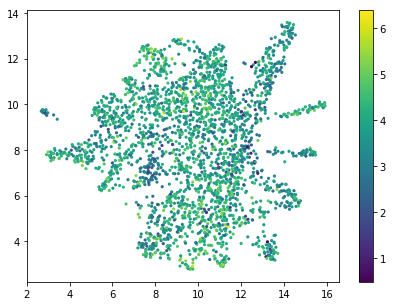

In [8]:
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = np.log10(enrollment),
s = 10, # size
edgecolor='none',
cmap='viridis'
)
plt.colorbar()
plt.show()

In [11]:
# LDA: Data preprocessing step for the unseen document
unseen_document = course_info['description'] + course_info['syllabus_headings'] + course_info['syllabus_descriptions']
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

#for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
#    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [34]:
file = open('simple_app/networkx_graph.pkl','wb')
pickle.dump(G, file)
file.close()

file = open('simple_app/networkx_values.pkl', 'wb')
pickle.dump(values, file)
file.close()

In [ ]:
# frequency plot

info_all = []
for i in processed_info:
    info_all.extend(i)
    
freq = nltk.FreqDist(dictionary)

fig = plt.figure(figsize=(20,4))
freq.plot(50, cumulative=False)
plt.show()

vals = freq.values()
words = freq.keys()
vals = vals[0:50]
words = words[0:50]
plt.bar(np.arange(50),vals)
plt.xticks(np.arange(50),words)
plt.show()